In [ ]:
!pip install tensorflow scikit-learn

# **Import Libraries and Load Data**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Conv1D, MaxPooling1D, Flatten, Dropout
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, precision_recall_curve


file_path_full_training_set = '/content/drive/MyDrive/LSTM KNN DDoS/KDDTrain+.txt'
file_path_test = '/content/drive/MyDrive/LSTM KNN DDoS/KDDTest+.txt'
df = pd.read_csv(file_path_full_training_set)
test_df = pd.read_csv(file_path_test)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Data Preprocessing**

In [ ]:
new_columns = (['duration', 'network_protocol', 'network_service', 'network_flag', 'source_bytes', 'destination_bytes',
                'land_flag', 'wrong_frag', 'urgent_flag', 'hot_value', 'failed_logins', 'logged_in_flag', 'compromised_num',
                'root_shell_flag', 'su_attempt_flag', 'root_num', 'file_creations_num', 'shells_num', 'access_files_num',
                'outbound_cmds_num', 'host_login_flag', 'guest_login_flag', 'count_value', 'service_count_value',
                'serror_rate', 'service_serror_rate', 'rerror_rate', 'service_rerror_rate', 'same_srv_rate',
                'diff_srv_rate', 'service_diff_host_rate', 'destination_host_count', 'destination_host_service_count',
                'destination_host_same_srv_rate', 'destination_host_diff_srv_rate', 'destination_host_same_src_port_rate',
                'destination_host_service_diff_host_rate', 'destination_host_serror_rate', 'destination_host_service_serror_rate',
                'destination_host_rerror_rate', 'destination_host_service_rerror_rate', 'security_attack_type', 'security_level'])

df.columns = new_columns
test_df.columns = new_columns

is_attack_flag = df.security_attack_type.map(lambda a: 0 if a == 'normal' else 1)
test_attack_flag = test_df.security_attack_type.map(lambda a: 0 if a == 'normal' else 1)

df['attack_flag'] = is_attack_flag
test_df['attack_flag'] = test_attack_flag


dos_attacks_list = ['apache2', 'back', 'land', 'neptune', 'mailbomb', 'pod', 'processtable', 'smurf', 'teardrop', 'udpstorm', 'worm']
probe_attacks_list = ['ipsweep', 'mscan', 'nmap', 'portsweep', 'saint', 'satan']
privilege_attacks_list = ['buffer_overflow', 'loadmdoule', 'perl', 'ps', 'rootkit', 'sqlattack', 'xterm']
access_attacks_list = ['ftp_write', 'guess_passwd', 'http_tunnel', 'imap', 'multihop', 'named', 'phf', 'sendmail', 'snmpgetattack',
                       'snmpguess', 'spy', 'warezclient', 'warezmaster', 'xclock', 'xsnoop']


attack_labels_list = ['Normal', 'DoS', 'Probe', 'Privilege', 'Access']


def map_security_attack(attack):
    if attack in dos_attacks_list:
        # DoS attacks map to 1
        attack_type = 1
    elif attack in probe_attacks_list:
        # Probe attacks map to 2
        attack_type = 2
    elif attack in privilege_attacks_list:
        # Privilege escalation attacks map to 3
        attack_type = 3
    elif attack in access_attacks_list:
        # Remote access attacks map to 4
        attack_type = 4
    else:
        # Normal maps to 0
        attack_type = 0

    return attack_type


security_attack_map = df.security_attack_type.apply(map_security_attack)
df['security_attack_map'] = security_attack_map

test_security_attack_map = test_df.security_attack_type.apply(map_security_attack)
test_df['security_attack_map'] = test_security_attack_map

label_encoder = LabelEncoder()
columns_list = ['network_protocol', 'network_service', 'network_flag', 'security_attack_type']
for col in columns_list:
    df[col] = label_encoder.fit_transform(df[col])
    test_df[col] = label_encoder.fit_transform(test_df[col])

df

,duration,network_protocol,network_service,network_flag,source_bytes,destination_bytes,land_flag,wrong_frag,urgent_flag,hot_value,...,destination_host_same_src_port_rate,destination_host_service_diff_host_rate,destination_host_serror_rate,destination_host_service_serror_rate,destination_host_rerror_rate,destination_host_service_rerror_rate,security_attack_type,security_level,attack_flag,security_attack_map
0,0,2,44,9,146,0,0,0,0,0,...,0.88,0.00,0.00,0.00,0.00,0.00,11,15,0,0
1,0,1,49,5,0,0,0,0,0,0,...,0.00,0.00,1.00,1.00,0.00,0.00,9,19,1,1
2,0,1,24,9,232,8153,0,0,0,0,...,0.03,0.04,0.03,0.01,0.00,0.01,11,21,0,0
3,0,1,24,9,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,11,21,0,0
4,0,1,49,1,0,0,0,0,0,0,...,0.00,0.00,0.00,0.00,1.00,1.00,9,21,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125967,0,1,49,5,0,0,0,0,0,0,...,0.00,0.00,1.00,1.00,0.00,0.00,9,20,1,1
125968,8,2,49,9,105,145,0,0,0,0,...,0.01,0.00,0.00,0.00,0.00,0.00,11,21,0,0
125969,0,1,54,9,2231,384,0,0,0,0,...,0.00,0.00,0.72,0.00,0.01,0.00,11,18,0,0
125970,0,1,30,5,0,0,0,0,0,0,...,0.00,0.00,1.00,1.00,0.00,0.00,9,20,1,1


# **Data Splitting and LSTM Model Construction**

In [ ]:
features = df.drop('attack_flag', axis=1)
features = features.drop('security_attack_type', axis=1)
features = features.drop('security_attack_map', axis=1)
features = features.drop('security_level', axis=1)
labels = df[['attack_flag']]


X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.20, random_state=42)


Epoch 1/10
363/363 [==============================] - 29s 32ms/step - loss: 0.1253 - accuracy: 0.9534 - val_loss: 0.0510 - val_accuracy: 0.9830
Epoch 2/10
363/363 [==============================] - 7s 18ms/step - loss: 0.0485 - accuracy: 0.9835 - val_loss: 0.0398 - val_accuracy: 0.9873
Epoch 3/10
363/363 [==============================] - 5s 14ms/step - loss: 0.0344 - accuracy: 0.9888 - val_loss: 0.0316 - val_accuracy: 0.9906
Epoch 4/10
363/363 [==============================] - 5s 13ms/step - loss: 0.0286 - accuracy: 0.9906 - val_loss: 0.0275 - val_accuracy: 0.9918
Epoch 5/10
363/363 [==============================] - 4s 12ms/step - loss: 0.0264 - accuracy: 0.9914 - val_loss: 0.0210 - val_accuracy: 0.9939
Epoch 6/10
363/363 [==============================] - 5s 13ms/step - loss: 0.0254 - accuracy: 0.9919 - val_loss: 0.0227 - val_accuracy: 0.9931
Epoch 7/10
363/363 [==============================] - 5s 13ms/step - loss: 0.0216 - accuracy: 0.9936 - val_loss: 0.0265 - val_accuracy: 0.992

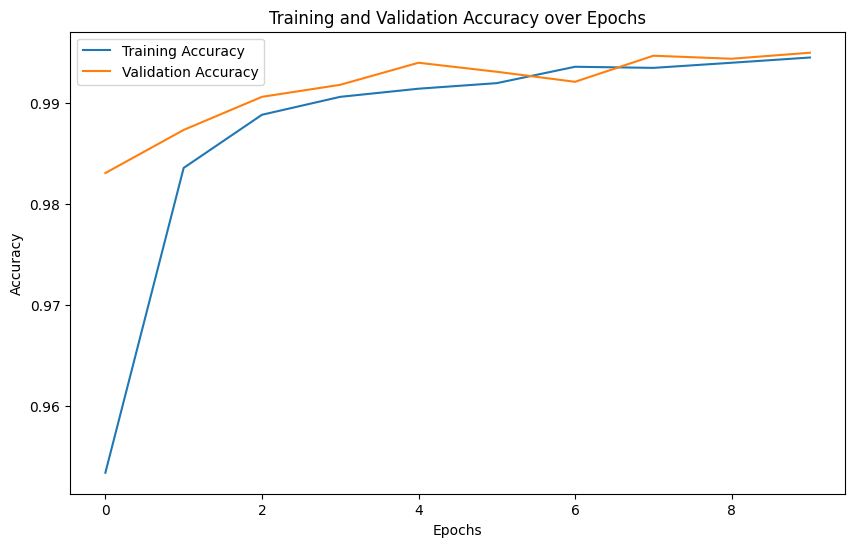

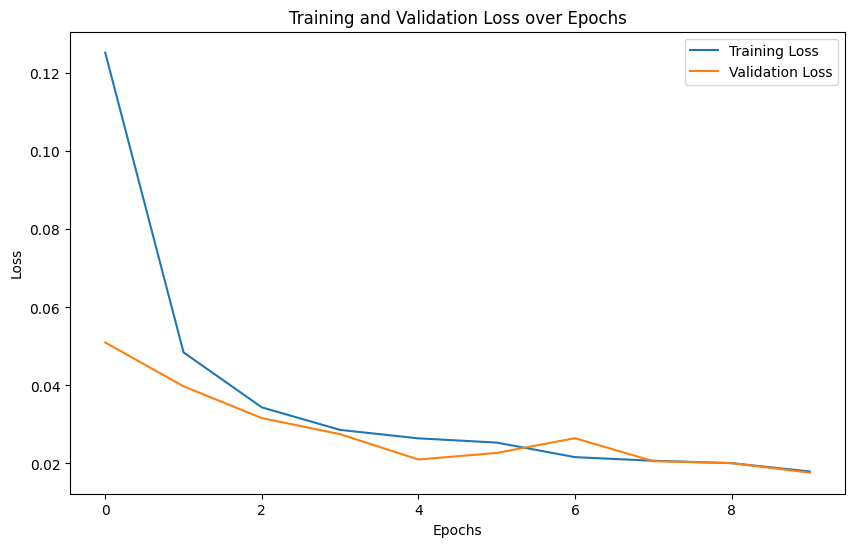

In [ ]:
X_train = np.array(X_train)
X_test = np.array(X_test)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
Y_train = np.array(Y_train)

model_lstm = Sequential()
model_lstm.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(64, return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(64, return_sequences=False))
model_lstm.add(Dense(units=1, activation='sigmoid'))

model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history_lstm = model_lstm.fit(X_train, Y_train, epochs=10, batch_size=250, validation_split=0.1)

plt.figure(figsize=(10, 6))
plt.plot(history_lstm.history['accuracy'], label='Training Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# **KNN Model Construction**

In [ ]:
X_train_lstm_embeddings = model_lstm.predict(X_train)
X_test_lstm_embeddings = model_lstm.predict(X_test)

X_train_lstm_embeddings = X_train_lstm_embeddings.reshape(X_train_lstm_embeddings.shape[0], -1)
X_test_lstm_embeddings = X_test_lstm_embeddings.reshape(X_test_lstm_embeddings.shape[0], -1)

model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(X_train_lstm_embeddings, Y_train)

788/788 [==============================] - 3s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier()

# **Model Evaluation and Reports**

788/788 [==============================] - 5s 6ms/step - loss: 0.0170 - accuracy: 0.9950
LSTM Model Test Loss: 0.016959864646196365
LSTM Model Test Accuracy: 0.9950386881828308
KNN Model Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     13386
           1       1.00      0.99      0.99     11809

    accuracy                           0.99     25195
   macro avg       0.99      0.99      0.99     25195
weighted avg       0.99      0.99      0.99     25195



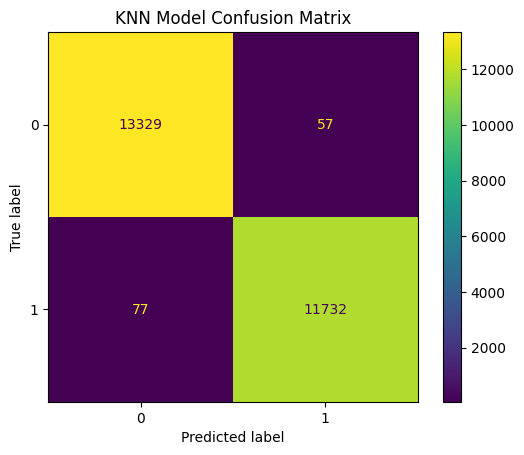

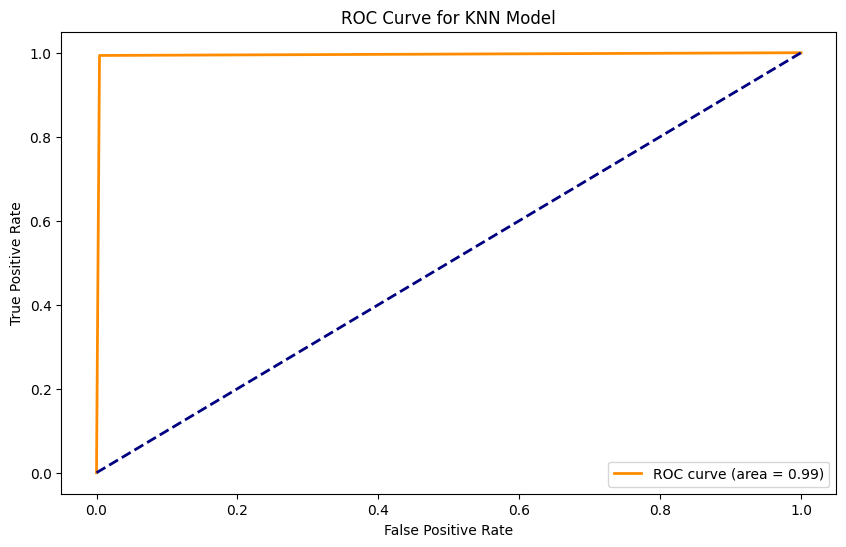

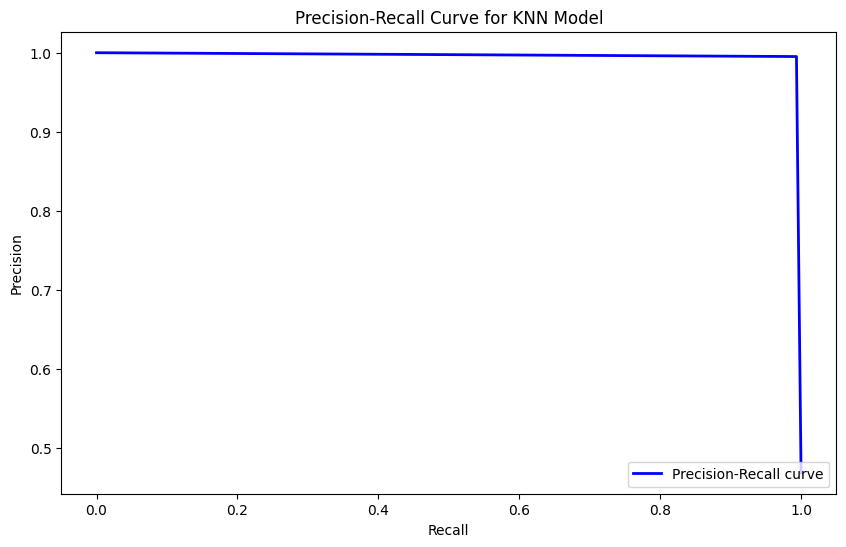

In [ ]:
test_results_lstm = model_lstm.evaluate(X_test, Y_test, verbose=1)
print("LSTM Model Test Loss:", test_results_lstm[0])
print("LSTM Model Test Accuracy:", test_results_lstm[1])

Y_pred_knn = model_knn.predict(X_test_lstm_embeddings)
report_knn = classification_report(Y_test, Y_pred_knn)
print("KNN Model Classification Report:")
print(report_knn)

cm_knn = confusion_matrix(Y_test, Y_pred_knn)
cm_display_knn = ConfusionMatrixDisplay(cm_knn)
cm_display_knn.plot()
plt.title('KNN Model Confusion Matrix')
plt.show()

fpr, tpr, _ = roc_curve(Y_test, Y_pred_knn)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for KNN Model')
plt.legend(loc='lower right')
plt.show()

precision, recall, _ = precision_recall_curve(Y_test, Y_pred_knn)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for KNN Model')
plt.legend(loc='lower right')
plt.show()